#### Preliminaries - import main libraries

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature
from skimage import color, io, exposure, feature
from skimage import transform as tf
from skimage.morphology import disk, diamond, square, opening, dilation, convex_hull_image
from skimage.morphology import remove_small_objects
from skimage.filters import  threshold_adaptive, threshold_otsu

from skimage.feature import corner_fast, corner_peaks, corner_orientations
from skimage.measure import find_contours, approximate_polygon

%matplotlib inline

#### Import test image

In [2]:
# import from url
url = 'http://www.spectrumgeo.com/wp-content/uploads/BPC-Bahamas-Data-Example.jpg'
img = np.asarray(io.imread(url))[:,:,:3]

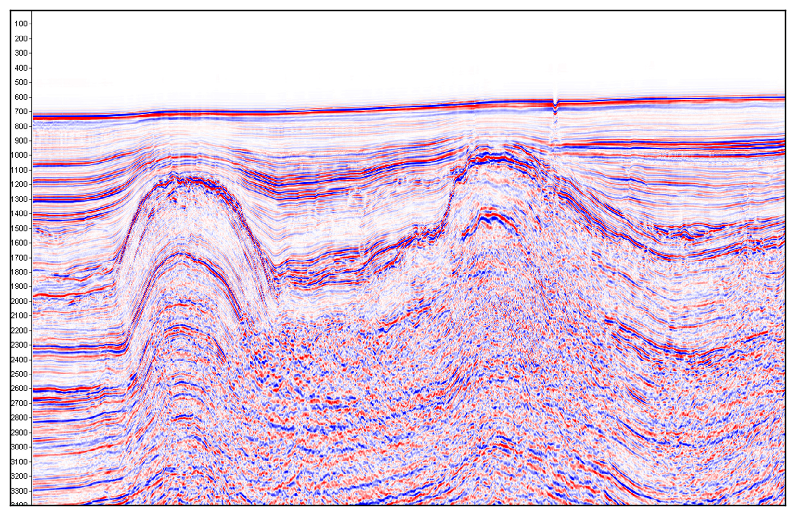

In [3]:
# plot it
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(img,  interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('input.png', dpi=400, bbox_inches='tight', pad_inches=0) 


#### Preporcessing

In [4]:
# Gray scal conversion and contrast stretching
gry = color.rgb2gray(img);
p2, p95 = np.percentile(gry, (2, 95))
rescale = exposure.rescale_intensity(gry, in_range=(p2, p95))

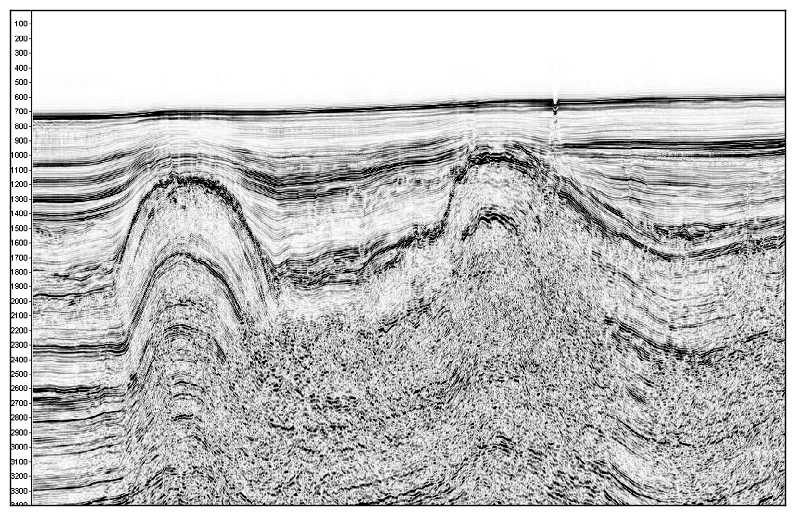

In [5]:
# plot it
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(rescale,  interpolation = 'none', cmap = 'gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('input.png', dpi=400, bbox_inches='tight', pad_inches=0) 

#### Convert to binary 

In [6]:
global_thresh = threshold_otsu(rescale)
binary_global = rescale < global_thresh

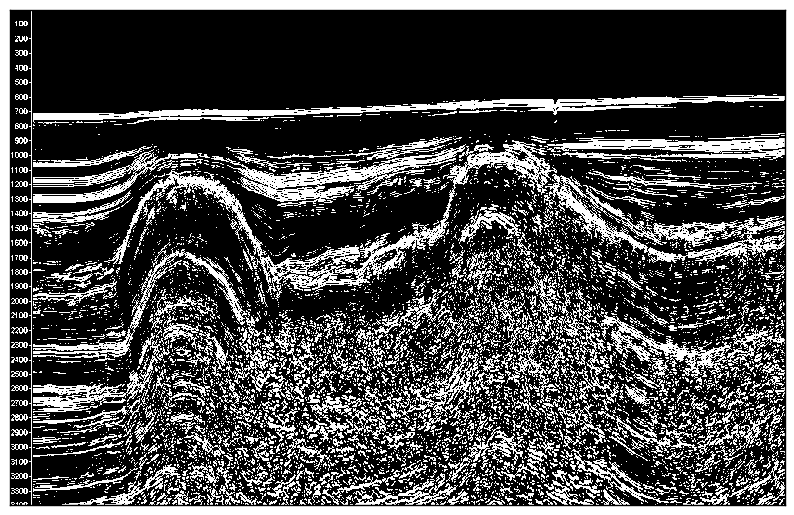

In [7]:
# plot it
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary_global,  interpolation = 'none', cmap = 'gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('input.png', dpi=400, bbox_inches='tight', pad_inches=0) 

#### Get largest element in the binary image

Detect largest bright element in the binary image. Making the assumption it would be the map.
Eliminate everything else (text, colorbar, holes, etc.).

In [8]:
# Label all white objects (made up of ones)
label_objects, nb_labels = ndi.label(binary_global) # ndimage.label actually labels 0 (background) as 0 and then 
                                                    # labels every nonzero object as 1, 2, ... n. 
    
# Calculate every labeled object's size. 
# np.bincount ignores whether input is an image or another type of array.
# It just calculates the binary sizes, including for the 0 (background).
sizes = np.bincount(label_objects.ravel())   

sizes[0] = 0    # This sets the size of the background to 0 so that if it happened to be larger than 
                # the largest white object it would not matter

# Keep only largest object
binary_objects = remove_small_objects(binary_global, max(sizes)) 

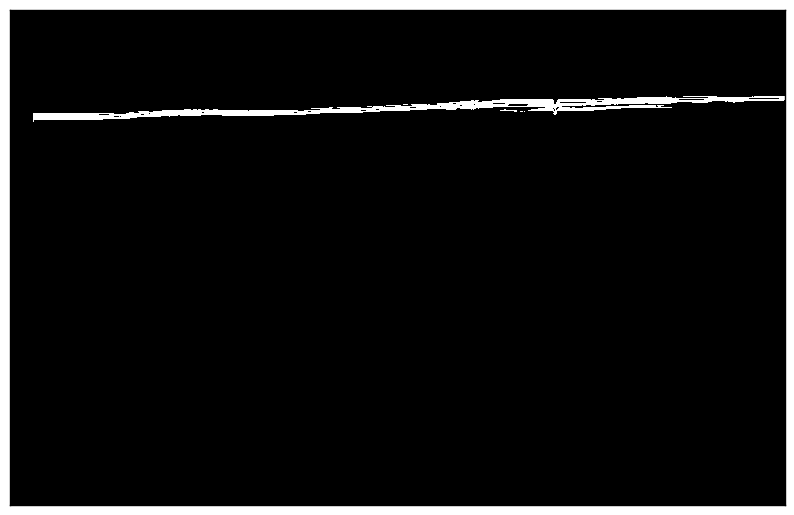

In [9]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary_objects, cmap='gray',  interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()
#fig.savefig('onlylargest.png', dpi=400, bbox_inches='tight', pad_inches=0) 

In [10]:
# Remove holes from it (black regions inside white object)
binary_holes = ndi.morphology.binary_fill_holes(binary_objects) 

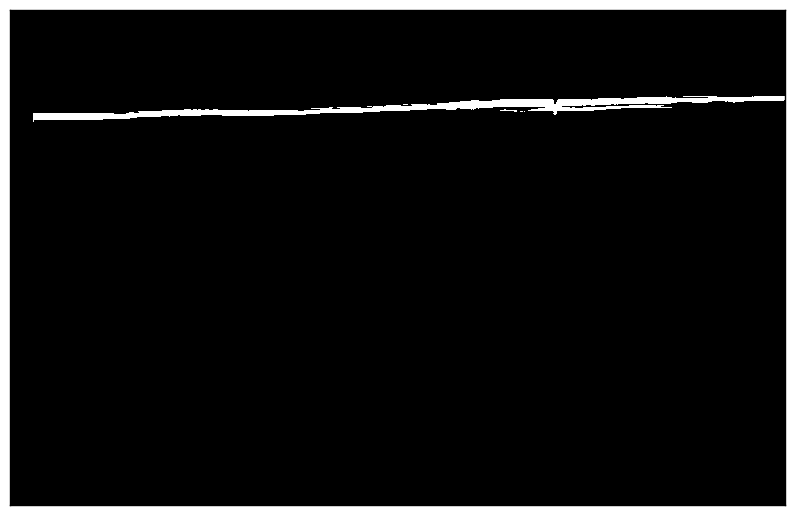

In [11]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary_holes, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#fig.savefig('noholes.png', dpi=400, bbox_inches='tight', pad_inches=0) 

In [12]:
enhanced = opening(binary_holes, disk(3))

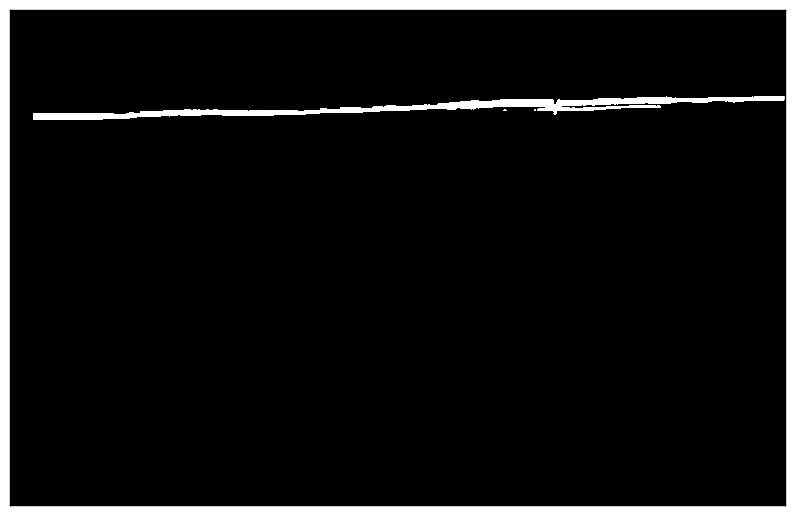

In [13]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(enhanced, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#fig.savefig('noholes.png', dpi=400, bbox_inches='tight', pad_inches=0) 

#### Find contour, approximate it with a quadrilateral, find and sort corners

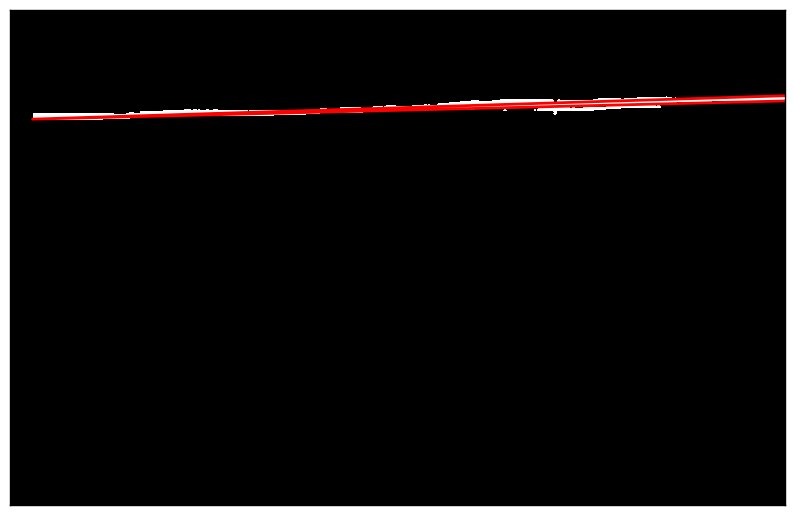

In [14]:
# test
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(enhanced, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

for contour in find_contours(enhanced, 0):
    coords = approximate_polygon(contour, tolerance=50)
    ax.plot(coords[:, 1], coords[:, 0], '-r', linewidth=2)
plt.show()

In [15]:
contour = np.squeeze(find_contours(enhanced, 0))
coords = approximate_polygon(contour, tolerance=50)
coords

IndexError: too many indices for array

In [ ]:
# Function to sort corners based on angle from centroid
# modified from: http://stackoverflow.com/a/31235064/1034648
def ordered(points):
    x = points[:,0]
    y = points[:,1]
    cx = np.mean(x)
    cy = np.mean(y)
    a = np.arctan2(y - cy, x - cx)
    order = a.ravel().argsort()
    x = x[order]
    y = y[order]
    return np.vstack([x,y])

In [ ]:
# sort the corners
# except the last one in the contour (repeatition of first point)
sortedCoords = ordered(coords[:-1]).T

# if we wanted to re-add it, by the way, we would do this
#sortedCoords =  np.concatenate([sortedCoords, sortedCoords[:1,:]], axis = 0) 
sortedCoords

In [ ]:
# just making sure points are indeed sorted

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(enhanced, cmap='gray', interpolation = 'none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

ax.scatter(sortedCoords[:, 1], sortedCoords[:, 0], s=60, color=['magenta', 'cyan', 'orange', 'green'])
plt.show()

### Nicely sorted counter-clocwise!!

#### Define size of output image based on largest width and height of input, and define destination coordinates for registration

In [ ]:
w1 = np.sqrt(((sortedCoords[0, 1]-sortedCoords[3, 1])**2)+((sortedCoords[0, 0]-sortedCoords[3, 0])**2))
w2 = np.sqrt(((sortedCoords[1, 1]-sortedCoords[2, 1])**2)+((sortedCoords[1, 0]-sortedCoords[2, 0])**2))

h1 = np.sqrt(((sortedCoords[0, 1]-sortedCoords[1, 1])**2)+((sortedCoords[0, 0]-sortedCoords[1, 0])**2))
h2 = np.sqrt(((sortedCoords[3, 1]-sortedCoords[2, 1])**2)+((sortedCoords[3, 0]-sortedCoords[2, 0])**2))

w = max(int(w1), int(w2))
h = max(int(h1), int(h2))

print h,w

In [ ]:
dst = np.array([
        [0, 0],
        [h-1, 0],
        [h-1, w-1],
        [0, w-1]], dtype = 'float32')
dst

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(dst[:, 1], dst[:, 0], s=60, color=['magenta', 'cyan', 'orange', 'green'])
plt.axis('equal')
plt.gca().invert_yaxis()
plt.show()

#### Rectify image by warping using homologous/corresponding points 

In [ ]:
dst[:,[0,1]] = dst[:,[1,0]]
sortedCoords[:,[0,1]] = sortedCoords[:,[1,0]]

In [ ]:
tform = tf.ProjectiveTransform()
tform.estimate(dst,sortedCoords)

In [ ]:
warped = tf.warp(img, tform, output_shape=(h-1, w-1))

fig, ax = plt.subplots(nrows=2, figsize=(20, 10))


ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])
ax[0].plot(sortedCoords[:, 0], sortedCoords[:, 1], '.r')

ax[1].imshow(warped, cmap=plt.cm.gray)
ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])